# Qubit Spectroscopy Analysis

## Introduction
To be able to perform computations with a qubit, we must calibrate it first. This tutorial describes how to do perform a qubit spectroscopy analysis, which is an essential step during the calibration of the qubit. After completing the tutorial you will know:

- How a single transmon qubit looks like on the chip
- How to find the readout resonator frequency
- How to find the qubit frequency

![](img/spectroscopy-introduction.png)


In order to run this tutorial you will need this notebook and the following packages installed in your environment (already done when you are running on the provided Jupyter server from CSC):
```
xarray==2023.9.0
scipy==1.11.2
matplotlib==3.8.0
numpy==1.23.5
lmfit==1.2.2
```

Furthermore, please go to [www.qal9000.se/qas23](www.qal9000.se/qas23) and retrieve a qubit spectroscopy measurement. It will be sent to your email address and should be in the .hdf5 format. If this page does not work for you, download a sample measurement here: [https://github.com/ENCCS/qas2023/tree/main/content/notebooks/datasets/spectroscopy_data.hdf5](https://github.com/ENCCS/qas2023/tree/main/content/notebooks/datasets/spectroscopy_data.hdf5). Please note that the service at  [www.qal9000.se/qas23](www.qal9000.se/qas23) is only available during the school. At other times, use the stored datafile on GitHub.

## A transmon qubit

The figure below depicts the basic design of a transmon qubit. Right in the middle there of the zoomed-in area there is the readout resonator, connected to the readout line. The actual qubit is the transmon on the right of the readout resonator. The qubit operates at a certain frequency, referred to as the qubit frequency f01. The qubit is in the ground state |0> until we send an electrical pulse with the correct frequency (f01) through the qubit drive line (on the very right of the zoomed-in area) to bring it into the excited state |1>. With this tutorial, you will learn how we can find the qubit frequency.

![](img/qubit-on-chip.png)

_Picture of a transmon qubit on a five qubit chip produced in Chalmers (Copyright: Anuj Aggarwal)_

## Readout resonator spectroscopy

You can think of the readout resonator as the qubit detector: the resonance frequency of this resonator changes if the qubit is excited. Typically, we have a rough estimate of the . resonator frequency given by its geometry. Without doing anything to the qubit, we send a signal through the feedline and we sweep the frequency of this signal. We then measure the signal at the output of the feedline. In the figure below you can see what happens for a sweep over the frequencies 6.850GHz-6.856GHz. We have a Lorentzian curve with its minimum at the frequency of the resonator. We see a deep because the signal, that we send, get absorbed by the resonator when it is at the frequency of the resonator. To extract this frequency we will apply a curve fit on the data points and retrieve the resonator frequency (fr = 6.853GHz), marked by the vertical blue line.

![](img/readout-resonator.png)

_Readout resonator spectroscopy analysis. The red line is the measured voltage for a qubit in ground state. The yellow line is the measured voltage for a qubit in excited state._

The yellow line in the picture depicts the behavior of the resonator when the qubit is in its |1> state. We do not know yet where this yellow line will be exactly, but we know that it is probably located left from the orange line. However, assuming the qubit would be in its excited state and that we measure our signal at the frequency corresponding to the qubit in the ground state, we would measure the voltage that corresponds to the intersection of the yellow line and the vertical blue line (16.5mv). We are taking advantage of the fact that the resonator frequency changes if the qubit is excited, to determine the qubit quantum state. This is what we will exploit in the next calibration step to determine the qubit frequency.

## Qubit spectroscopy

In this calibration step, we want to find out the frequency (f01) at which we can bring the qubit form its ground to excited state. From geometrical properties of the qubit, we have a rough range in which we should search for this frequency. We continuously monitor the signal at the output of the feedline at the frequency of the resonator corresponding to the qubit in the ground state (fr,as we determined in the previous step).

Now, in addition, we send a signal to the qubit through its own drive line at different frequencies. If this frequency does not correspond to f01, the qubit does not get excited and qubit is not excited, we expect to measure the lower voltage on the readout signal. As soon as the frequency hits f01, the qubit is excited and the readout resonator will switch to its |1> state curve. Hence, if we keep measuring the output signal at the frequency fr, we will measure a larger signal. So, if we plot the measured signal at fr as a function of the qubit drive frequency, we expect to see a peak centered at the qubit frequency f01. By fitting this curve (as shown in the live exercise below), we can extract the value of f01.

![](img/qubit-spectroscopy.png)

_Qubit spectroscopy analysis step by step. We collect the data points and then apply a fit function._

### Live exercise: qubit spectroscopy analysis
As described above, we must fit a function over the measurement values of the sweep. For the qubit spectroscopy, we know that the shape of the function follows a Lorentzian function. Thus, in our experiment, we are loading the fit function described below:

In [3]:
# (C) Eleftherios Moschandreou, 2023

import numpy as np
import xarray as xr
import lmfit


# Lorentzian function that is fit to qubit spectroscopy peaks
def lorentzian_function(x: float, x0: float, width: float, A: float, c: float, ) -> float:
    return A * width ** 2 / ((x - x0) ** 2 + width ** 2) + c


class LorentzianModel(lmfit.model.Model):
    """
    Generate a Lorentzian model that can be fit to qubit spectroscopy data.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(lorentzian_function, *args, **kwargs)

        self.set_param_hint("x0", vary=True)
        self.set_param_hint("A", vary=True)
        self.set_param_hint("c", vary=True)
        self.set_param_hint("width", vary=True)

    def guess(self, data, **kws) -> lmfit.parameter.Parameters:
        x = kws.get("x", None)

        if x is None:
            return None

        # Guess that the resonance is where the function takes its maximal value
        x0_guess = x[np.argmax(data)]
        self.set_param_hint("x0", value=x0_guess)

        # Guess width
        width_guess = 0.5e6
        self.set_param_hint("width", value=width_guess)

        # The guess for the vertical offset is the mean absolute value of the data
        c_guess = np.mean(data)
        self.set_param_hint("c", value=c_guess)

        # Calculate A_guess from difference between the peak and the backround level
        A_guess = (np.max(data) - c_guess)
        self.set_param_hint("A", value=A_guess)

        params = self.make_params()
        return lmfit.models.update_param_vals(params, self.prefix, **kws)


class QubitSpectroscopyAnalysis():
    """
    Analysis that fits a Lorentzian function to qubit spectroscopy data.
    The resulting fit can be analyzed to determine if a peak was found or not.
    """

    def __init__(self, dataset: xr.Dataset):
        data_var = list(dataset.data_vars.keys())[0]
        coord = list(dataset[data_var].coords.keys())[0]
        self.S21 = dataset[data_var].values
        self.independents = dataset[coord].values
        self.magnitudes = np.absolute(self.S21)
        self.fit_frequencies = None
        self.fit_y = None

    def run_fitting(self):
        # Initialize the Lorentzian model
        model = LorentzianModel()

        # Fetch the resulting measurement variables from self
        frequencies = self.independents
        self.fit_frequencies = np.linspace(frequencies[0], frequencies[-1], 1000)  # x-values for plotting

        # Gives an initial guess for the model parameters and then fits the model to the data.
        guess = model.guess(self.magnitudes, x=frequencies)
        fit_result = model.fit(self.magnitudes, params=guess, x=frequencies)

        self.fit_y = model.eval(fit_result.params, **{model.independent_vars[0]: self.fit_frequencies})
        return fit_result.params['x0'].value

    def plotter(self, ax_, qubit_):
        # Plots the data and the fitted model of a qubit spectroscopy experiment
        ax_.plot(self.fit_frequencies, self.fit_y, 'r-', lw=3.0)
        ax_.plot(self.independents, self.magnitudes, 'bo-', ms=3.0)
        ax_.set_title(f'Qubit Spectroscopy for {qubit_}')
        ax_.set_xlabel('frequency (Hz)')
        ax_.set_ylabel('|S21| (V)')
        ax_.grid()


If you have not done it yet, you can now request a dataset from the [www.qal9000.se/qas23](www.qal9000.se/qas23) webpage or from [https://github.com/ENCCS/qas2023/tree/main/content/notebooks/datasets/spectroscopy_data.hdf5](https://github.com/ENCCS/qas2023/tree/main/content/notebooks/datasets/spectroscopy_data.hdf5). It will contain the frequency and voltage values for the spectroscopy measurements of one real qubit. Replace the file name in the script below with the file you got by email and run it. You should expect an output that has a peak.

The qubit frequency is: 4.009GHz


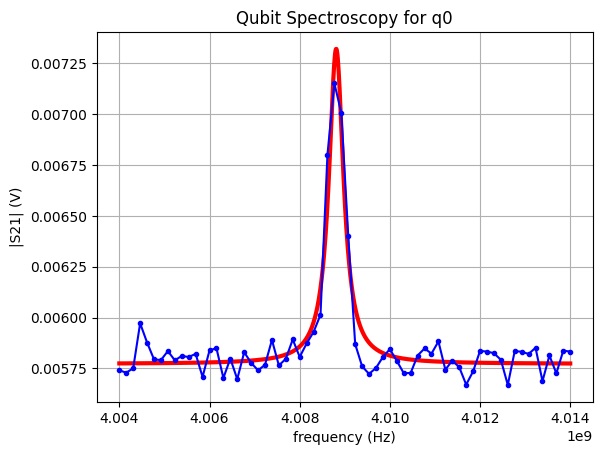

In [2]:
import xarray
import matplotlib.pyplot as plt

# TODO: Replace the file name
ds = xarray.open_dataset('<FILE_YOU_GOT_BY_EMAIL>.hdf5')
analysis = QubitSpectroscopyAnalysis(ds)
fitted_frequency = analysis.run_fitting()

fig, ax = plt.subplots(1, 1)
analysis.plotter(ax, 'q0')
print(f'The qubit frequency is: {fitted_frequency * 10e-10:.3f}GHz')
plt.show()